In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv(r'C:\Users\jdrij\OneDrive\Bureaublad\Master\ML_Github\ML4QS-project\data\train_df.csv')

In [3]:
def split_train_val(df, n_groups=5, val_group=0):
    grouped = []

    for label in df['transport_mode'].unique():
        df_label = df[df['transport_mode'] == label].copy()
        df_label = df_label.sort_values(by='Time').reset_index(drop=True)  # <-- chronologische volgorde

        # Verdeel in ongeveer gelijke groepen
        split_groups = np.array_split(df_label, n_groups)
        for i, group in enumerate(split_groups):
            group['group'] = i
            grouped.append(group)

    df_grouped = pd.concat(grouped).reset_index(drop=True)

    val_set = df_grouped[df_grouped['group'] == val_group]
    train_set = df_grouped[df_grouped['group'] != val_group]

    return train_set.drop(columns=['group']), val_set.drop(columns=['group'])

# Voorbeeld gebruik:
train_df_hyper, val_df_hyper = split_train_val(train_df, val_group=0)

c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [4]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder

# ------------------------------------------
# Standaardmodel (default XGBClassifier)
# ------------------------------------------

X_train_xgb = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_xgb = train_df_hyper['transport_mode']

X_val_xgb = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_xgb = val_df_hyper['transport_mode']

# -----------------------------
# Stap 2: Encode labels
# -----------------------------
le_xgb = LabelEncoder()
y_train_enc_xgb = le_xgb.fit_transform(y_train_xgb)
y_val_enc_xgb = le_xgb.transform(y_val_xgb)

print("Label mapping (XGB):", dict(zip(le_xgb.classes_, le_xgb.transform(le_xgb.classes_))))


default_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
default_xgb.fit(X_train_xgb, y_train_enc_xgb)

y_train_pred_default = default_xgb.predict(X_train_xgb)
y_val_pred_default = default_xgb.predict(X_val_xgb)

train_acc_default = accuracy_score(y_train_enc_xgb, y_train_pred_default)
val_acc_default = accuracy_score(y_val_enc_xgb, y_val_pred_default)

print("\n=== Accuracy van standaard XGBClassifier ===")
print(f"→ Train Accuracy:      {train_acc_default:.4f}")
print(f"→ Validation Accuracy: {val_acc_default:.4f}")

# ------------------------------------------
# Jouw model met handmatige hyperparameters
# ------------------------------------------
custom_xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=4,
    n_estimators=200,
    random_state=42,
    reg_alpha=0,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
custom_xgb.fit(X_train_xgb, y_train_enc_xgb)

y_train_pred_custom = custom_xgb.predict(X_train_xgb)
y_val_pred_custom = custom_xgb.predict(X_val_xgb)

train_acc_custom = accuracy_score(y_train_enc_xgb, y_train_pred_custom)
val_acc_custom = accuracy_score(y_val_enc_xgb, y_val_pred_custom)

print("\n=== Accuracy van jouw custom XGBClassifier ===")
print(f"→ Train Accuracy:      {train_acc_custom:.4f}")
print(f"→ Validation Accuracy: {val_acc_custom:.4f}")


Label mapping (XGB): {'auto': 0, 'fietsen': 1, 'metro': 2, 'rennen': 3, 'trein': 4}


c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Accuracy van standaard XGBClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9808


c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Accuracy van jouw custom XGBClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 1.0000


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Data voorbereiden
# -----------------------------
X_train_rf = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_rf = train_df_hyper['transport_mode']

X_val_rf = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_rf = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_rf = LabelEncoder()
y_train_enc_rf = le_rf.fit_transform(y_train_rf)
y_val_enc_rf = le_rf.transform(y_val_rf)

print("Label mapping (RF):", dict(zip(le_rf.classes_, le_rf.transform(le_rf.classes_))))

# -----------------------------
# Standaardmodel (default RF)
# -----------------------------
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train_rf, y_train_enc_rf)

y_train_pred_default_rf = default_rf.predict(X_train_rf)
y_val_pred_default_rf = default_rf.predict(X_val_rf)

train_acc_default_rf = accuracy_score(y_train_enc_rf, y_train_pred_default_rf)
val_acc_default_rf = accuracy_score(y_val_enc_rf, y_val_pred_default_rf)

print("\n=== Accuracy van standaard RandomForestClassifier ===")
print(f"→ Train Accuracy:      {train_acc_default_rf:.4f}")
print(f"→ Validation Accuracy: {val_acc_default_rf:.4f}")

# -----------------------------
# Jouw model met hyperparameters
# -----------------------------
custom_rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=50,
    random_state=42
)
custom_rf.fit(X_train_rf, y_train_enc_rf)

y_train_pred_custom_rf = custom_rf.predict(X_train_rf)
y_val_pred_custom_rf = custom_rf.predict(X_val_rf)

train_acc_custom_rf = accuracy_score(y_train_enc_rf, y_train_pred_custom_rf)
val_acc_custom_rf = accuracy_score(y_val_enc_rf, y_val_pred_custom_rf)

print("\n=== Accuracy van jouw custom RandomForestClassifier ===")
print(f"→ Train Accuracy:      {train_acc_custom_rf:.4f}")
print(f"→ Validation Accuracy: {val_acc_custom_rf:.4f}")


Label mapping (RF): {'auto': 0, 'fietsen': 1, 'metro': 2, 'rennen': 3, 'trein': 4}

=== Accuracy van standaard RandomForestClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9872

=== Accuracy van jouw custom RandomForestClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 1.0000


In [6]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Data voorbereiden
# -----------------------------
X_train_cb = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_cb = train_df_hyper['transport_mode']

X_val_cb = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_cb = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_cb = LabelEncoder()
y_train_enc_cb = le_cb.fit_transform(y_train_cb)
y_val_enc_cb = le_cb.transform(y_val_cb)

print("Label mapping (CatBoost):", dict(zip(le_cb.classes_, le_cb.transform(le_cb.classes_))))

# -----------------------------
# Standaardmodel (default CatBoost)
# -----------------------------
default_cb = CatBoostClassifier(
    random_state=42,
    verbose=0  # zet op 100 als je wél output wil
)
default_cb.fit(X_train_cb, y_train_enc_cb)

y_train_pred_default_cb = default_cb.predict(X_train_cb)
y_val_pred_default_cb = default_cb.predict(X_val_cb)

train_acc_default_cb = accuracy_score(y_train_enc_cb, y_train_pred_default_cb)
val_acc_default_cb = accuracy_score(y_val_enc_cb, y_val_pred_default_cb)

print("\n=== Accuracy van standaard CatBoostClassifier ===")
print(f"→ Train Accuracy:      {train_acc_default_cb:.4f}")
print(f"→ Validation Accuracy: {val_acc_default_cb:.4f}")

# -----------------------------
# Jouw model met hyperparameters
# -----------------------------
custom_cb = CatBoostClassifier(
    random_state=42,
    iterations=400,
    learning_rate=0.15,
    depth=6,
    verbose=0  # stille training
)
custom_cb.fit(X_train_cb, y_train_enc_cb)

y_train_pred_custom_cb = custom_cb.predict(X_train_cb)
y_val_pred_custom_cb = custom_cb.predict(X_val_cb)

train_acc_custom_cb = accuracy_score(y_train_enc_cb, y_train_pred_custom_cb)
val_acc_custom_cb = accuracy_score(y_val_enc_cb, y_val_pred_custom_cb)

print("\n=== Accuracy van jouw custom CatBoostClassifier ===")
print(f"→ Train Accuracy:      {train_acc_custom_cb:.4f}")
print(f"→ Validation Accuracy: {val_acc_custom_cb:.4f}")


Label mapping (CatBoost): {'auto': 0, 'fietsen': 1, 'metro': 2, 'rennen': 3, 'trein': 4}

=== Accuracy van standaard CatBoostClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9859

=== Accuracy van jouw custom CatBoostClassifier ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9910


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# -----------------------------
# Data voorbereiden
# -----------------------------
X_train_logreg = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_logreg = train_df_hyper['transport_mode']

X_val_logreg = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_logreg = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_logreg = LabelEncoder()
y_train_enc_logreg = le_logreg.fit_transform(y_train_logreg)
y_val_enc_logreg = le_logreg.transform(y_val_logreg)

print("Label mapping (LogReg):", dict(zip(le_logreg.classes_, le_logreg.transform(le_logreg.classes_))))

# -----------------------------
# Schalen van features
# -----------------------------
scaler_logreg = StandardScaler()
X_train_scaled_logreg = scaler_logreg.fit_transform(X_train_logreg)
X_val_scaled_logreg = scaler_logreg.transform(X_val_logreg)

# -----------------------------
# Standaardmodel
# -----------------------------
default_logreg = LogisticRegression()
default_logreg.fit(X_train_scaled_logreg, y_train_enc_logreg)

y_train_pred_default_logreg = default_logreg.predict(X_train_scaled_logreg)
y_val_pred_default_logreg = default_logreg.predict(X_val_scaled_logreg)

train_acc_default_logreg = accuracy_score(y_train_enc_logreg, y_train_pred_default_logreg)
val_acc_default_logreg = accuracy_score(y_val_enc_logreg, y_val_pred_default_logreg)

print("\n=== Accuracy van standaard LogisticRegression ===")
print(f"→ Train Accuracy:      {train_acc_default_logreg:.4f}")
print(f"→ Validation Accuracy: {val_acc_default_logreg:.4f}")

# -----------------------------
# Jouw model
# -----------------------------
custom_logreg = LogisticRegression(
    C=10,
    max_iter=500,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)
custom_logreg.fit(X_train_scaled_logreg, y_train_enc_logreg)

y_train_pred_custom_logreg = custom_logreg.predict(X_train_scaled_logreg)
y_val_pred_custom_logreg = custom_logreg.predict(X_val_scaled_logreg)

train_acc_custom_logreg = accuracy_score(y_train_enc_logreg, y_train_pred_custom_logreg)
val_acc_custom_logreg = accuracy_score(y_val_enc_logreg, y_val_pred_custom_logreg)

print("\n=== Accuracy van jouw custom LogisticRegression ===")
print(f"→ Train Accuracy:      {train_acc_custom_logreg:.4f}")
print(f"→ Validation Accuracy: {val_acc_custom_logreg:.4f}")


Label mapping (LogReg): {'auto': 0, 'fietsen': 1, 'metro': 2, 'rennen': 3, 'trein': 4}

=== Accuracy van standaard LogisticRegression ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9974

=== Accuracy van jouw custom LogisticRegression ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9974


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# -----------------------------
# Data voorbereiden
# -----------------------------
X_train_knn = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_knn = train_df_hyper['transport_mode']

X_val_knn = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_knn = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_knn = LabelEncoder()
y_train_enc_knn = le_knn.fit_transform(y_train_knn)
y_val_enc_knn = le_knn.transform(y_val_knn)

print("Label mapping (KNN):", dict(zip(le_knn.classes_, le_knn.transform(le_knn.classes_))))

# -----------------------------
# Schalen van features
# -----------------------------
scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train_knn)
X_val_scaled_knn = scaler_knn.transform(X_val_knn)

# -----------------------------
# Standaardmodel
# -----------------------------
default_knn = KNeighborsClassifier()
default_knn.fit(X_train_scaled_knn, y_train_enc_knn)

y_train_pred_default_knn = default_knn.predict(X_train_scaled_knn)
y_val_pred_default_knn = default_knn.predict(X_val_scaled_knn)

train_acc_default_knn = accuracy_score(y_train_enc_knn, y_train_pred_default_knn)
val_acc_default_knn = accuracy_score(y_val_enc_knn, y_val_pred_default_knn)

print("\n=== Accuracy van standaard KNN ===")
print(f"→ Train Accuracy:      {train_acc_default_knn:.4f}")
print(f"→ Validation Accuracy: {val_acc_default_knn:.4f}")

# -----------------------------
# Jouw model
# -----------------------------
custom_knn = KNeighborsClassifier(
    n_neighbors=5,
    p=1,
    weights='uniform'
)
custom_knn.fit(X_train_scaled_knn, y_train_enc_knn)

y_train_pred_custom_knn = custom_knn.predict(X_train_scaled_knn)
y_val_pred_custom_knn = custom_knn.predict(X_val_scaled_knn)

train_acc_custom_knn = accuracy_score(y_train_enc_knn, y_train_pred_custom_knn)
val_acc_custom_knn = accuracy_score(y_val_enc_knn, y_val_pred_custom_knn)

print("\n=== Accuracy van jouw custom KNN ===")
print(f"→ Train Accuracy:      {train_acc_custom_knn:.4f}")
print(f"→ Validation Accuracy: {val_acc_custom_knn:.4f}")


Label mapping (KNN): {'auto': 0, 'fietsen': 1, 'metro': 2, 'rennen': 3, 'trein': 4}

=== Accuracy van standaard KNN ===
→ Train Accuracy:      0.9997
→ Validation Accuracy: 0.9590

=== Accuracy van jouw custom KNN ===
→ Train Accuracy:      1.0000
→ Validation Accuracy: 0.9821


c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters:

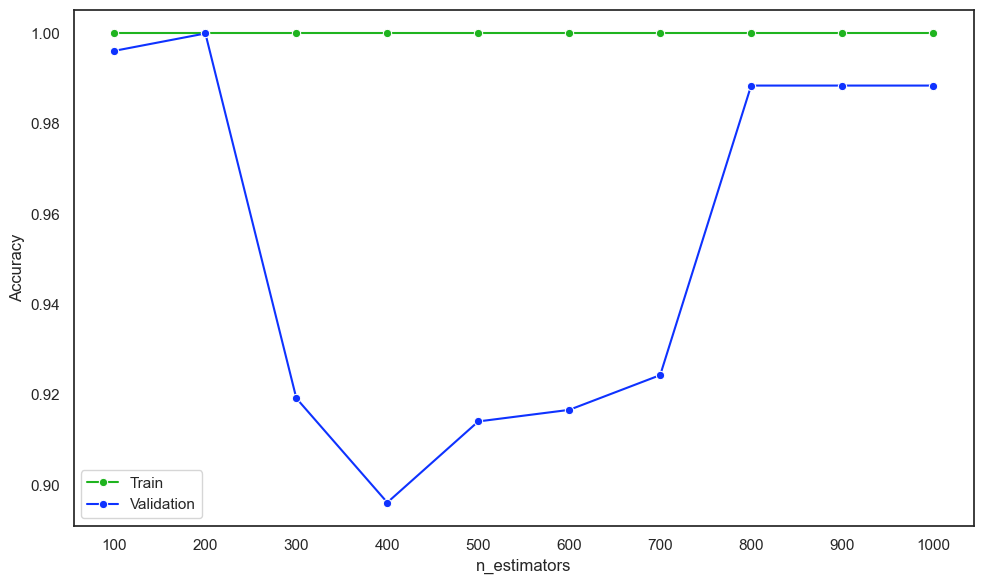

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Set Seaborn style

# -----------------------------
# Data preparation
# -----------------------------
X_train = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train = train_df_hyper['transport_mode']
X_val = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# -----------------------------
# Define parameter sweep
# -----------------------------
n_estimators_range = list(range(100, 1001, 100))  # 100 to 1000 step 100

results = []

for n in n_estimators_range:
    model = XGBClassifier(
        learning_rate=0.01,
        max_depth=4,
        n_estimators=n,
        random_state=42,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train_enc)

    train_acc = accuracy_score(y_train_enc, model.predict(X_train))
    val_acc = accuracy_score(y_val_enc, model.predict(X_val))

    results.append({'n_estimators': n, 'Set': 'Train', 'Accuracy': train_acc})
    results.append({'n_estimators': n, 'Set': 'Validation', 'Accuracy': val_acc})

results_df = pd.DataFrame(results)

# -----------------------------
# Plot with Seaborn
# -----------------------------
sns.set_style("white")
# Example: custom color palette
custom_colors = ["#1fb41f", "#0e32ff"]  # Add more colors if needed

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='n_estimators',
    y='Accuracy',
    hue='Set',
    marker='o',
    palette=custom_colors  # Change colors here
)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title=None, fontsize=11)
plt.xticks(n_estimators_range)

plt.grid(False)  # Remove grid
plt.tight_layout()

# Save high-resolution image
plt.savefig("xgb_accuracy_vs_n_estimators.png", dpi=600)

# Show plot
plt.show()

c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters:

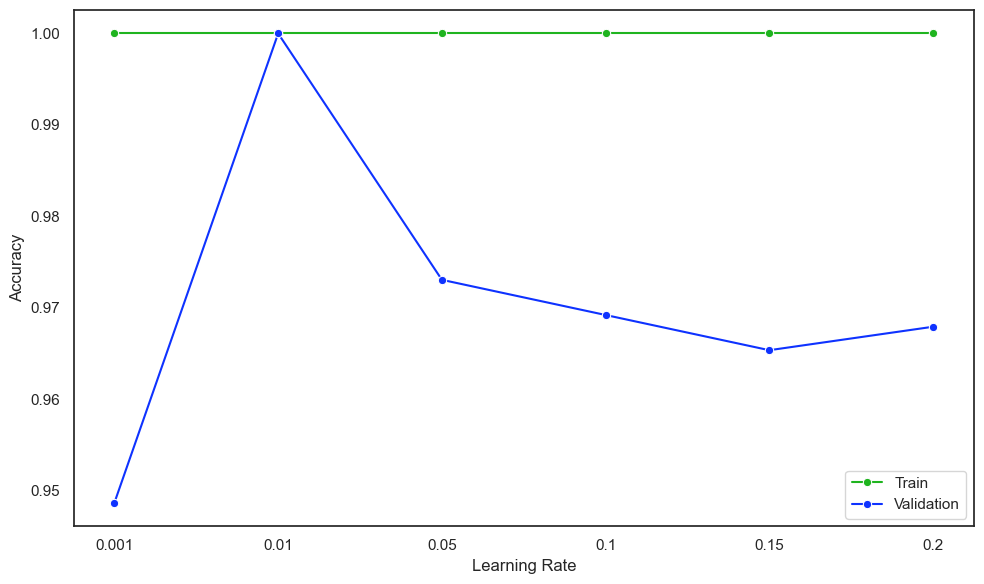

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


# -----------------------------
# Data preparation
# -----------------------------
X_train_lr = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_lr = train_df_hyper['transport_mode']
X_val_lr = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_lr = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_lr = LabelEncoder()
y_train_enc_lr = le_lr.fit_transform(y_train_lr)
y_val_enc_lr = le_lr.transform(y_val_lr)

# -----------------------------
# Define learning rate sweep
# -----------------------------
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]
n_estimators_fixed = 200

results_lr = []

for lr in learning_rates:
    model_lr = XGBClassifier(
        learning_rate=lr,
        max_depth=4,
        n_estimators=n_estimators_fixed,
        random_state=42,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model_lr.fit(X_train_lr, y_train_enc_lr)

    train_acc_lr = accuracy_score(y_train_enc_lr, model_lr.predict(X_train_lr))
    val_acc_lr = accuracy_score(y_val_enc_lr, model_lr.predict(X_val_lr))

    results_lr.append({'learning_rate': lr, 'Set': 'Train', 'Accuracy': train_acc_lr})
    results_lr.append({'learning_rate': lr, 'Set': 'Validation', 'Accuracy': val_acc_lr})

results_df_lr = pd.DataFrame(results_lr)

results_df_lr['learning_rate_str'] = results_df_lr['learning_rate'].astype(str)

sns.set_style("white")
custom_colors_lr = ["#1fb41f", "#0e32ff"]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df_lr,
    x='learning_rate_str',  # Categorical x-axis
    y='Accuracy',
    hue='Set',
    marker='o',
    palette=custom_colors_lr
)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title=None, fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save high-resolution image
plt.savefig("xgb_accuracy_vs_learning_rate_sweep_fixed_spacing.png", dpi=600)

# Show plot
plt.show()

c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jdrij\anaconda3\envs\condaenv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters:

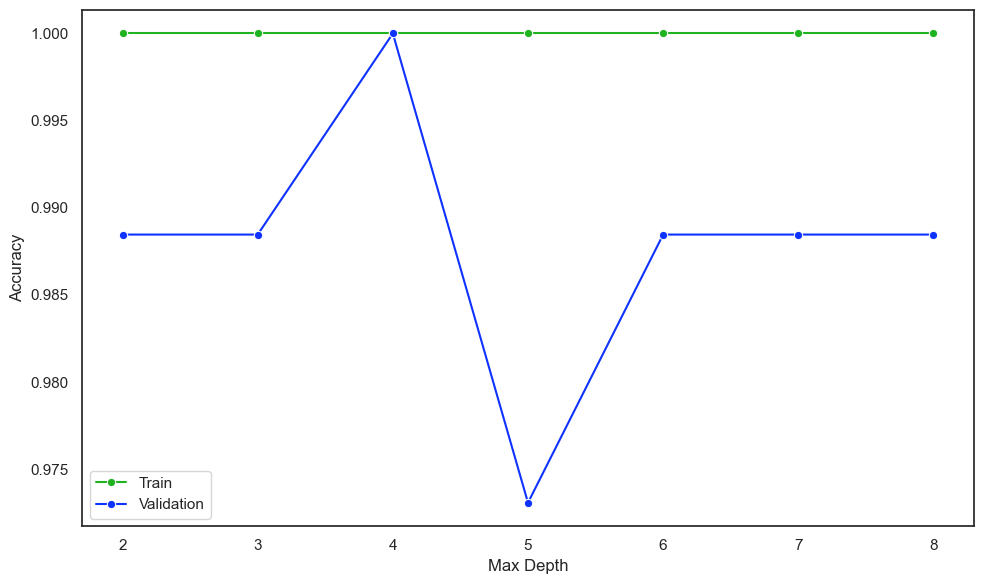

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# -----------------------------
# Data preparation
# -----------------------------
X_train_md = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_md = train_df_hyper['transport_mode']
X_val_md = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_md = val_df_hyper['transport_mode']

# -----------------------------
# Encode labels
# -----------------------------
le_md = LabelEncoder()
y_train_enc_md = le_md.fit_transform(y_train_md)
y_val_enc_md = le_md.transform(y_val_md)

# -----------------------------
# Define max_depth sweep
# -----------------------------
max_depth_range = [2, 3, 4, 5, 6, 7, 8]
learning_rate_fixed = 0.01
n_estimators_fixed = 200

results_md = []

for depth in max_depth_range:
    model_md = XGBClassifier(
        learning_rate=learning_rate_fixed,
        max_depth=depth,
        n_estimators=n_estimators_fixed,
        random_state=42,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model_md.fit(X_train_md, y_train_enc_md)

    train_acc_md = accuracy_score(y_train_enc_md, model_md.predict(X_train_md))
    val_acc_md = accuracy_score(y_val_enc_md, model_md.predict(X_val_md))

    results_md.append({'max_depth': depth, 'Set': 'Train', 'Accuracy': train_acc_md})
    results_md.append({'max_depth': depth, 'Set': 'Validation', 'Accuracy': val_acc_md})

results_df_md = pd.DataFrame(results_md)

# Convert to string for equal spacing on x-axis
results_df_md['max_depth_str'] = results_df_md['max_depth'].astype(str)

# -----------------------------
# Plot with Seaborn
# -----------------------------
sns.set_style("white")
custom_colors_md = ["#1fb41f", "#0e32ff"]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df_md,
    x='max_depth_str',  # Categorical x-axis for equal spacing
    y='Accuracy',
    hue='Set',
    marker='o',
    palette=custom_colors_md
)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title=None, fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save high-resolution image
plt.savefig("xgb_accuracy_vs_max_depth_sweep_fixed_spacing.png", dpi=600)

# Show plot
plt.show()
